
 Imports libraries needed for timing, randomness, statistics, data structures (heap queue), type hinting, and plotting experiment results. This sets up the environment and tools for the knapsack algorithm comparisons and analysis.

In [5]:
import time
import random
import statistics
import heapq
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

Defines functions to create single or multiple knapsack instances with configurable properties like item count, cost/weight limits, and value/weight relationships. These functions provide the data (knapsack problems) for testing the different algorithms.

In [6]:
def generate_instance(num_items, max_cost, max_weight, granularity=1, cost_weight_corr=None, weight_distribution='bal', k=1) -> List[Tuple[int, int]]:
    items = []
    for _ in range(num_items):
        if weight_distribution == 'light':
            weight = max(1, int((1 - random.random() ** k) * max_weight))
        elif weight_distribution == 'heavy':
            weight = max(1, int((random.random() ** k) * max_weight))
        else:
            weight = random.randint(1, max_weight)

        if cost_weight_corr == 'corr':
            cost = int(weight * (max_cost / max_weight))
        elif cost_weight_corr == 'strong':
            cost = int(weight * (max_cost / max_weight) * 1.5)
        else:
            cost = random.randint(1, max_cost)

        cost = (cost // granularity) * granularity
        weight = (weight // granularity) * granularity

        items.append((cost, weight))

    return items

def generate_instances(num_instances, num_items, max_cost, max_weight, granularity=1, cost_weight_corr=None, weight_distribution='bal', k=1) -> List[List[Tuple[int, int]]]:
    return [generate_instance(num_items, max_cost, max_weight, granularity, cost_weight_corr, weight_distribution, k) for _ in range(num_instances)]

 Implements the brute force algorithm, checking every possible combination of items to find the optimal solution for the knapsack problem. It guarantees optimality but becomes very slow as the number of items increases due to exponential complexity.

In [ ]:
def brute_force_knapsack(values: List[int], weights: List[int], W: int) -> Tuple[int, int]:
        n = len(values)
        max_value = 0
        num_steps = 0

        for i in range(2**n):
            total_weight = 0
            total_value = 0
            for j in range(n):
                num_steps += 1
                if (i >> j) & 1:
                    total_weight += weights[j]
                    total_value += values[j]
            if total_weight <= W and total_value > max_value:
                max_value = total_value

        return max_value, num_steps

 This cell is a duplicate of Cell 3, containing the same brute force knapsack implementation. It has no new logical function beyond the previous cell.

In [7]:
def brute_force_knapsack(values: List[int], weights: List[int], W: int) -> Tuple[int, int]:
        n = len(values)
        max_value = 0
        num_steps = 0

        for i in range(2**n):
            total_weight = 0
            total_value = 0
            for j in range(n):
                num_steps += 1
                if (i >> j) & 1:
                    total_weight += weights[j]
                    total_value += values[j]
            if total_weight <= W and total_value > max_value:
                max_value = total_value

        return max_value, num_steps

 Implements the Branch and Bound algorithm, using a priority queue and an upper bound estimation to efficiently explore the solution space. It aims to find the optimal solution faster than brute force by pruning branches unlikely to contain the optimum.

In [10]:
class Node:
    def __init__(self, level: int, value: int, weight: int, bound: float):
        self.level = level
        self.value = value
        self.weight = weight
        self.bound = bound

    def __lt__(self, other: 'Node'):
        return self.bound > other.bound

def bound(node: Node, n: int, W: int, values: List[int], weights: List[int]) -> float:
    if node.weight >= W:
        return 0
    profit_bound = node.value
    j = node.level + 1
    totweight = node.weight
    while j < n and totweight + weights[j] <= W:
        totweight += weights[j]
        profit_bound += values[j]
        j += 1
    if j < n:
        profit_bound += (W - totweight) * values[j] / weights[j]
    return profit_bound

def branch_and_bound_knapsack(values: List[int], weights: List[int], W: int) -> Tuple[int, int]:
    n = len(values)
    pq = []
    v = Node(-1, 0, 0, 0)
    max_value = 0
    num_steps = 0

    v.bound = bound(v, n, W, values, weights)
    heapq.heappush(pq, v)

    while pq:
        v = heapq.heappop(pq)
        if v.bound > max_value:
            if v.level + 1 < n:
                u = Node(v.level + 1, v.value + values[v.level + 1], v.weight + weights[v.level + 1], 0)
                num_steps += 1
                if u.weight <= W and u.value > max_value:
                    max_value = u.value
                u.bound = bound(u, n, W, values, weights)
                if u.bound > max_value:
                    heapq.heappush(pq, u)

                u = Node(v.level + 1, v.value, v.weight, 0)
                num_steps += 1
                u.bound = bound(u, n, W, values, weights)
                if u.bound > max_value:
                    heapq.heappush(pq, u)

    return max_value, num_steps

Implements the dynamic programming algorithm, building a table to store optimal solutions for subproblems to efficiently solve the overall knapsack problem. This method finds the optimal solution in pseudo-polynomial time, dependent on the knapsack capacity and item values.

In [11]:
def dynamic_programming_knapsack(values: List[int], weights: List[int], W: int) -> Tuple[int, int]:
        n = len(values)
        K = [[0 for x in range(W + 1)] for x in range(n + 1)]
        num_steps = 0

        for i in range(n + 1):
            for w in range(W + 1):
                num_steps += 1
                if i == 0 or w == 0:
                    K[i][w] = 0
                elif weights[i-1] <= w:
                    K[i][w] = max(values[i-1] + K[i-1][w-weights[i-1]], K[i-1][w])
                else:
                    K[i][w] = K[i-1][w]

        return K[n][W], num_steps

 Implements a greedy heuristic that sorts items by value-to-weight ratio and picks the best items first until the knapsack is full. This is a fast approximation that doesn't guarantee the optimal solution but provides a reasonable answer quickly.

In [12]:
def cost_weight_heuristic_knapsack(values: List[int], weights: List[int], W: int) -> Tuple[int, int]:
        non_zero_items = [(v, w) for v, w in zip(values, weights) if w != 0]
        if not non_zero_items:
            return 0, 0

        values, weights = zip(*non_zero_items)
        index = list(range(len(values)))
        ratio = [v/w for v, w in zip(values, weights)]
        index.sort(key=lambda i: ratio[i], reverse=True)

        max_value = 0
        total_weight = 0
        num_steps = 0
        for i in index:
            num_steps += 1
            if total_weight + weights[i] <= W:
                total_weight += weights[i]
                max_value += values[i]
            else:
                break

        return max_value, num_steps

 Contains utility functions to convert knapsack instances between list format and string representation, and to randomly reorder items within a string instance. These help in managing and potentially modifying the format of the instance data for experiments.

In [13]:
def permute_instance(instance: str) -> str:
    iid, count, capacity, *items = instance.split(" ")
    pairs = list(zip(items[::2], items[1::2]))
    random.shuffle(pairs)
    return " ".join([iid, count, capacity] + list(sum(pairs, ())))

def instance_to_string(instance: List[Tuple[int, int]], iid: str) -> str:
    count = len(instance)
    capacity = sum(weight for _, weight in instance)  # or use a specific capacity
    items = " ".join(f"{cost} {weight}" for cost, weight in instance)
    return f"{iid} {count} {capacity} {items}"

def string_to_instance(instance_str: str) -> Tuple[str, int, int, List[Tuple[int, int]]]:
    parts = instance_str.split()
    iid = parts[0]
    count = int(parts[1])
    capacity = int(parts[2])
    items = [(int(parts[i]), int(parts[i+1])) for i in range(3, len(parts), 2)]
    return iid, count, capacity, items

 Sets up and runs a large-scale experiment comparing the four algorithms on many generated knapsack instances, measuring their runtimes and calculating summary statistics. It provides initial performance data on average runtime and variance for each algorithm under specific conditions.

In [14]:
def run_experiment(num_instances: int, num_items: int, max_cost: int, max_weight: int, permute_fraction=0.2, granularity=1, cost_weight_corr=None, weight_distribution='bal', k=1) -> Dict[str, Dict[str, float]]:
    instances = generate_instances(num_instances, num_items, max_cost, max_weight, granularity, cost_weight_corr, weight_distribution, k)
    permute_indices = random.sample(range(num_instances), int(permute_fraction * num_instances))
    print('No of permuted items', len(permute_indices))

    results = {
        'greedy_heuristic': [],
        'branch_and_bound': [],
        'dynamic_programming': [],
        'brute_force': []
    }

    def time_algorithm(algorithm, *args) -> Tuple[Tuple[int, int], float]:
        start_time = time.time()
        result = algorithm(*args)
        end_time = time.time()
        return result, end_time - start_time

    for i, instance in enumerate(instances):
        iid = f"inst_{i+1}"
        instance_str = instance_to_string(instance, iid)

        if i in permute_indices:
            instance_str = permute_instance(instance_str)

        iid, count, capacity, instance = string_to_instance(instance_str)

        values = [cost for cost, weight in instance]
        weights = [weight for cost, weight in instance]

        W = capacity  # Assuming the permuted capacity remains valid

        # Brute Force
        bf_result, bf_time = time_algorithm(brute_force_knapsack, values, weights, W)
        results['brute_force'].append(bf_time)

        # Branch and Bound
        bb_result, bb_time = time_algorithm(branch_and_bound_knapsack, values, weights, W)
        results['branch_and_bound'].append(bb_time)

        # Dynamic Programming
        dp_result, dp_time = time_algorithm(dynamic_programming_knapsack, values, weights, W)
        results['dynamic_programming'].append(dp_time)

        # Greedy Heuristic
        gh_result, gh_time = time_algorithm(cost_weight_heuristic_knapsack, values, weights, W)
        results['greedy_heuristic'].append(gh_time)

    summary = {}
    for method, times in results.items():
        summary[method] = {
            'mean_runtime': statistics.mean(times),
            'variance_runtime': statistics.variance(times)
        }

    return summary

num_instances = 1000
num_items = 15
max_cost = 100
max_weight = 50
permute_fraction = 0.5  # Fraction of instances to permute

# Run the experiment
experiment_summary = run_experiment(num_instances, num_items, max_cost, max_weight, permute_fraction)

# Display the summary
for method, stats in experiment_summary.items():
    print(f"{method}: Mean Runtime = {stats['mean_runtime']:.8f} seconds, Variance Runtime = {stats['variance_runtime']:.8f}")

def run_algorithms(values, weights, W):
    results = {}
    def time_algorithm(algorithm, *args):
        start_time = time.time()
        result = algorithm(*args)
        end_time = time.time()
        return result, end_time - start_time

    # Run Brute Force
    bf_result, bf_time = time_algorithm(brute_force_knapsack, values, weights, W)
    results['brute_force'] = bf_result, bf_time

    # Run Branch and Bound
    bb_result, bb_time = time_algorithm(branch_and_bound_knapsack, values, weights, W)
    results['branch_and_bound'] = bb_result, bb_time

    # Run Dynamic Programming
    dp_result, dp_time = time_algorithm(dynamic_programming_knapsack, values, weights, W)
    results['dynamic_programming'] = dp_result, dp_time

    # Run Greedy Heuristic
    gh_result, gh_time = time_algorithm(cost_weight_heuristic_knapsack, values, weights, W)
    results['greedy_heuristic'] = gh_result, gh_time

    return results

No of permuted items 500
greedy_heuristic: Mean Runtime = 0.00002573 seconds, Variance Runtime = 0.00000000
branch_and_bound: Mean Runtime = 0.00008984 seconds, Variance Runtime = 0.00000000
dynamic_programming: Mean Runtime = 0.00236551 seconds, Variance Runtime = 0.00000136
brute_force: Mean Runtime = 0.06542947 seconds, Variance Runtime = 0.00032822


Defines functions to systematically analyze and plot the runtime of the algorithms as key instance parameters (like number of items, max cost/weight, capacity) are varied. This allows for a detailed investigation of how different problem characteristics impact each algorithm's efficiency.

In [16]:
def plot_results(x_values, results, x_label, y_label, title, yscale='linear'):
    plt.figure(figsize=(10, 6))
    for method, values in results.items():
        plt.plot(x_values, values, label=method)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.yscale(yscale)
    plt.legend()
    plt.show()

def analyze_instance_size(num_instances, num_items_range, max_cost, max_weight, capacity_ratio):
    runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    relative_errors = []

    for num_items in num_items_range:
        instance_runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_errors = []

        instances = generate_instances(num_instances, num_items, max_cost, max_weight)
        for instance in instances:
            values = [cost for cost, weight in instance]
            weights = [weight for cost, weight in instance]
            W = int(capacity_ratio * sum(weights))

            results = run_algorithms(values, weights, W)

            for method in runtimes.keys():
                runtime = results[method][1]
                instance_runtimes[method].append(runtime)
                instance_steps[method].append(results[method][0][1])

            heuristic_value = results['greedy_heuristic'][0][0]
            optimal_value = max(results[method][0][0] for method in results.keys())
            relative_error = (optimal_value - heuristic_value) / optimal_value
            instance_errors.append(relative_error)

        for method in runtimes.keys():
            runtimes[method].append(statistics.mean(instance_runtimes[method]))
            steps[method].append(statistics.mean(instance_steps[method]))
        relative_errors.append(statistics.mean(instance_errors))

    plot_results(num_items_range, runtimes, 'Instance Size (# of items)', 'Runtime (seconds)', 'Runtime vs. Instance Size', yscale='log')

def analyze_max_cost(num_instances, num_items, max_cost_range, max_weight, capacity_ratio):
    runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

    for max_cost in max_cost_range:
        instance_runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

        instances = generate_instances(num_instances, num_items, max_cost, max_weight)
        for instance in instances:
            values = [cost for cost, weight in instance]
            weights = [weight for cost, weight in instance]
            W = int(capacity_ratio * sum(weights))

            results = run_algorithms(values, weights, W)

            for method in runtimes.keys():
                runtime = results[method][1]
                instance_runtimes[method].append(runtime)
                instance_steps[method].append(results[method][0][1])

        for method in runtimes.keys():
            runtimes[method].append(statistics.mean(instance_runtimes[method]))
            steps[method].append(statistics.mean(instance_steps[method]))

    plot_results(max_cost_range, runtimes, 'Maximum Cost', 'Runtime (seconds)', 'Runtime vs. Maximum Cost', yscale='log')

def analyze_max_weight(num_instances, num_items, max_cost, max_weight_range, capacity_ratio):
    runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

    for max_weight in max_weight_range:
        instance_runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

        instances = generate_instances(num_instances, num_items, max_cost, max_weight)
        for instance in instances:
            values = [cost for cost, weight in instance]
            weights = [weight for cost, weight in instance]
            W = int(capacity_ratio * sum(weights))

            results = run_algorithms(values, weights, W)

            for method in runtimes.keys():
                runtime = results[method][1]
                instance_runtimes[method].append(runtime)
                instance_steps[method].append(results[method][0][1])

        for method in runtimes.keys():
            runtimes[method].append(statistics.mean(instance_runtimes[method]))
            steps[method].append(statistics.mean(instance_steps[method]))

    plot_results(max_weight_range, runtimes, 'Maximum Weight', 'Runtime (seconds)', 'Runtime vs. Maximum Weight', yscale='log')

def analyze_capacity_ratio(num_instances, num_items, max_cost, max_weight, capacity_ratio_range):
    runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

    for capacity_ratio in capacity_ratio_range:
        instance_runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

        instances = generate_instances(num_instances, num_items, max_cost, max_weight)
        for instance in instances:
            values = [cost for cost, weight in instance]
            weights = [weight for cost, weight in instance]
            W = int(capacity_ratio * sum(weights))

            results = run_algorithms(values, weights, W)

            for method in runtimes.keys():
                runtime = results[method][1]
                instance_runtimes[method].append(runtime)
                instance_steps[method].append(results[method][0][1])

        for method in runtimes.keys():
            runtimes[method].append(statistics.mean(instance_runtimes[method]))
            steps[method].append(statistics.mean(instance_steps[method]))

    plot_results(capacity_ratio_range, runtimes, 'Knapsack Capacity to Total Weight Ratio', 'Runtime (seconds)', 'Runtime vs. Knapsack Capacity to Total Weight Ratio', yscale='log')

def analyze_cost_weight_corr(num_instances, num_items, max_cost, max_weight, capacity_ratio, correlation_types):
    runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

    for cost_weight_corr in correlation_types:
        instance_runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

        instances = generate_instances(num_instances, num_items, max_cost, max_weight, cost_weight_corr=cost_weight_corr)
        for instance in instances:
            values = [cost for cost, weight in instance]
            weights = [weight for cost, weight in instance]
            W = int(capacity_ratio * sum(weights))

            results = run_algorithms(values, weights, W)

            for method in runtimes.keys():
                runtime = results[method][1]
                instance_runtimes[method].append(runtime)
                instance_steps[method].append(results[method][0][1])

        for method in runtimes.keys():
            runtimes[method].append(statistics.mean(instance_runtimes[method]))
            steps[method].append(statistics.mean(instance_steps[method]))

    plot_results(correlation_types, runtimes, 'Cost/Weight Correlation', 'Runtime (seconds)', 'Runtime vs. Cost/Weight Correlation', yscale='log')

def analyze_granularity(num_instances, num_items, max_cost, max_weight, capacity_ratio, granularity_range):
    runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
    steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

    for granularity in granularity_range:
        instance_runtimes = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}
        instance_steps = {'brute_force': [], 'branch_and_bound': [], 'dynamic_programming': [], 'greedy_heuristic': []}

        instances = generate_instances(num_instances, num_items, max_cost, max_weight, granularity=granularity)
        for instance in instances:
            values = [cost for cost, weight in instance]
            weights = [weight for cost, weight in instance]
            W = int(capacity_ratio * sum(weights))

            results = run_algorithms(values, weights, W)

            for method in runtimes.keys():
                runtime = results[method][1]
                instance_runtimes[method].append(runtime)
                instance_steps[method].append(results[method][0][1])

        for method in runtimes.keys():
            runtimes[method].append(statistics.mean(instance_runtimes[method]))
            steps[method].append(statistics.mean(instance_steps[method]))

    plot_results(granularity_range, runtimes, 'Granularity', 'Runtime (seconds)', 'Runtime vs. Granularity', yscale='log')

Sets the specific parameter ranges and values for the analyses defined in the previous cell and then executes these analyses. This runs the experiments that generate the plots showing the performance of algorithms under varying instance properties.

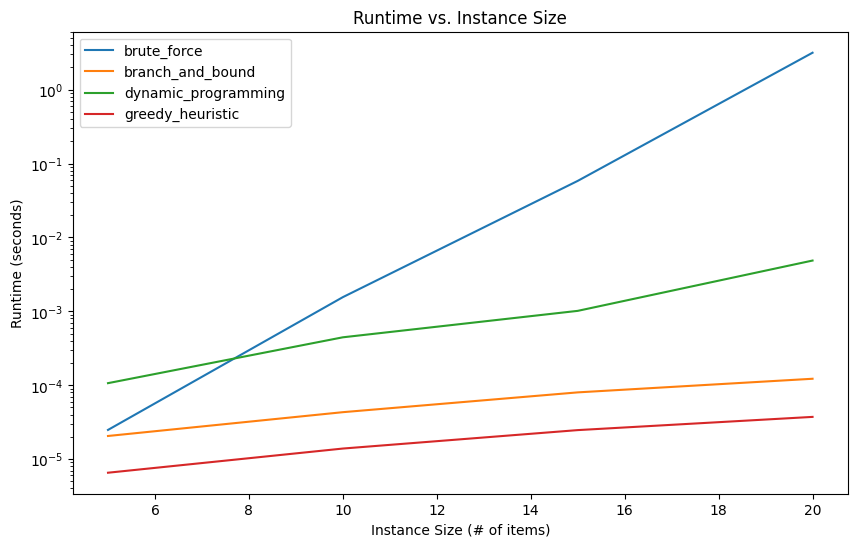

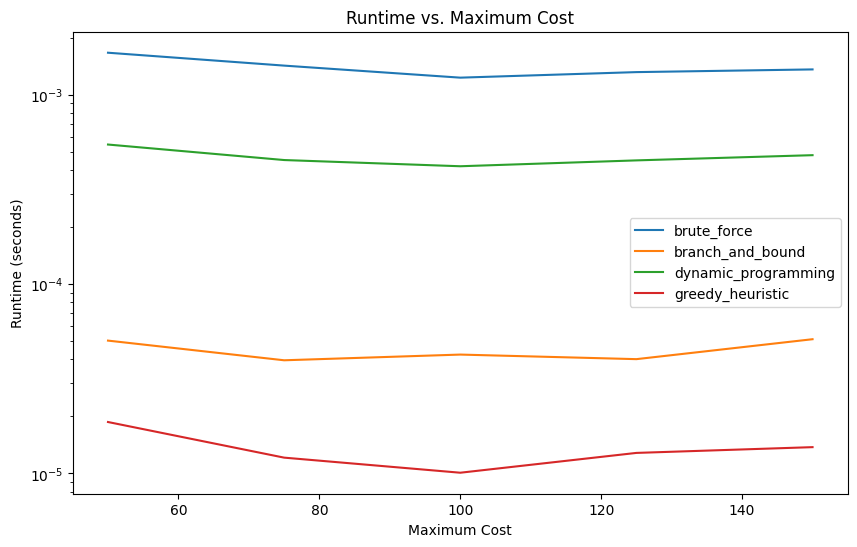

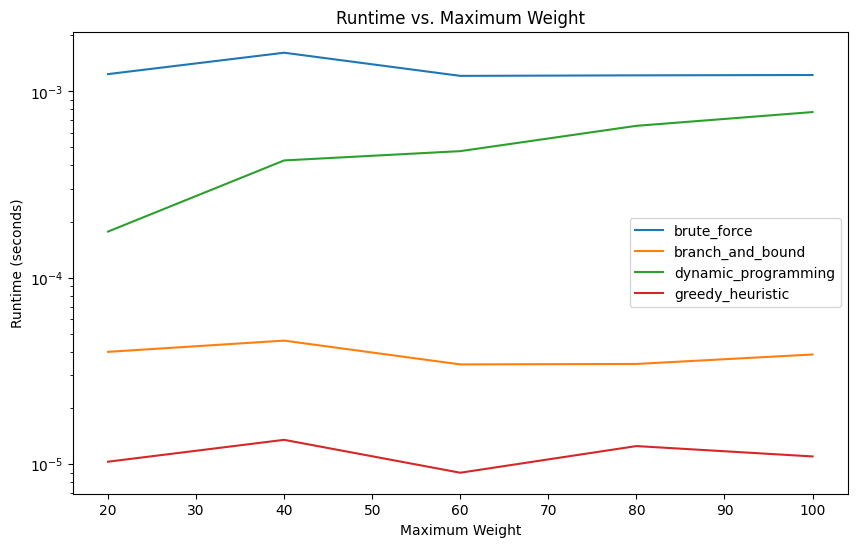

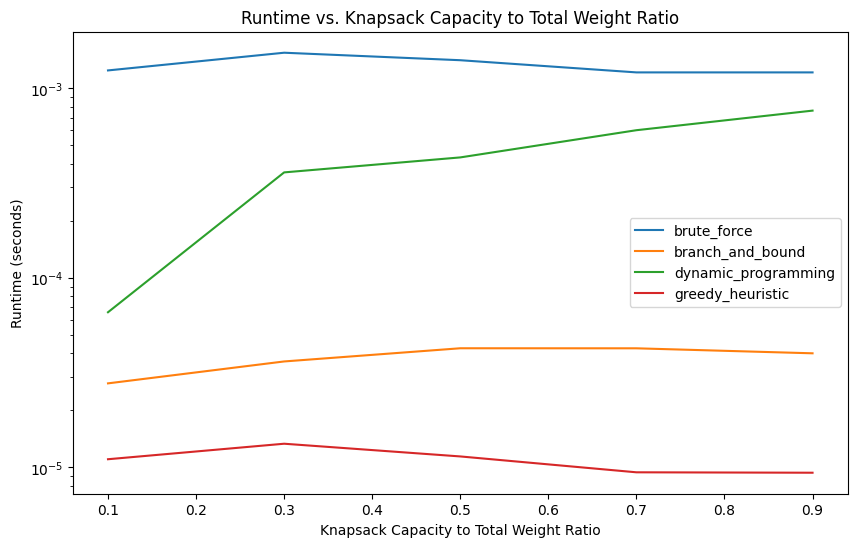

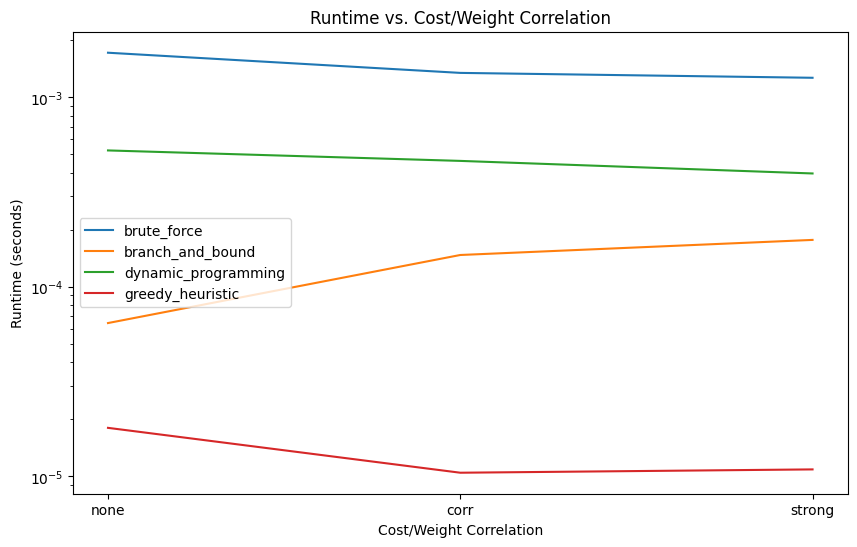

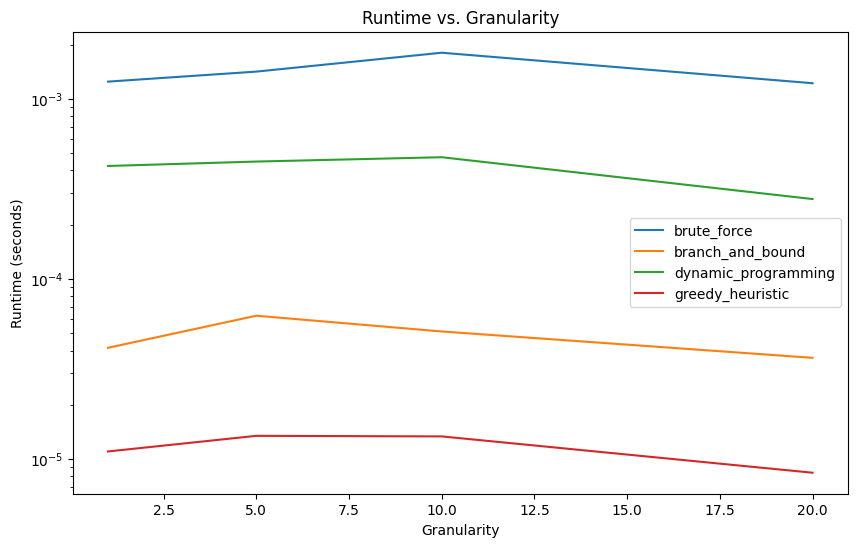

In [17]:
# Parameters for the experiment
num_instances = 10
num_items_range = range(5, 21, 5)
max_cost = 100
max_weight = 50
capacity_ratio = 0.5

# Analyze instance size
analyze_instance_size(num_instances, num_items_range, max_cost, max_weight, capacity_ratio)

# Analyze maximum cost
max_cost_range = range(50, 151, 25)
analyze_max_cost(num_instances, 10, max_cost_range, max_weight, capacity_ratio)

# Analyze maximum weight
max_weight_range = range(20, 101, 20)
analyze_max_weight(num_instances, 10, max_cost, max_weight_range, capacity_ratio)

# Analyze knapsack capacity to total weight ratio
capacity_ratio_range = [0.1, 0.3, 0.5, 0.7, 0.9]
analyze_capacity_ratio(num_instances, 10, max_cost, max_weight, capacity_ratio_range)

# Analyze cost/weight correlation
correlation_types = ['none', 'corr', 'strong']
analyze_cost_weight_corr(num_instances, 10, max_cost, max_weight, 0.5, correlation_types)

# Analyze granularity
granularity_range = [1, 5, 10, 20]
analyze_granularity(num_instances, 10, max_cost, max_weight, 0.5, granularity_range)